# RNN vs LSTM vs GRU — Hands-on Demo
**RNN, LSTM, and GRU** process text and shows an easy-to-follow sentiment analysis example.

## Objectives

- Understand *why* sequential models are needed for text.
- Build and compare three models: **SimpleRNN**, **LSTM**, and **GRU**.
- Train each model on the IMDB sentiment dataset (binary classification).
- Compare training curves and evaluation metrics.

## Runtime & Requirements

- Python 3.7+
- TensorFlow 2.x (includes Keras API)
- numpy, matplotlib

If you are on Colab, run:

```bash
# (Optional) only if TensorFlow is not already available
!pip install -q tensorflow
```

In [1]:
# 1) Imports
# Run this cell to import required libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

print('Imports OK')

Imports OK


## 2) Load IMDB dataset (pre-tokenized)

Keras provides a pre-tokenized IMDB dataset where words are replaced by integer indices. We will load a subset for a fast demo.

In [2]:
# Load IMDB dataset (use top 10k words)
VOCAB_SIZE = 10000
MAXLEN = 200  # max words per review

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)
print('Samples:', len(x_train), 'train,', len(x_test), 'test')

# Quick look at a sample (integer tokens)
print('\nExample tokenized review (first):')
print(x_train[0][:30], '...')

# Pad sequences to MAXLEN
x_train_pad = pad_sequences(x_train, maxlen=MAXLEN)
x_test_pad = pad_sequences(x_test, maxlen=MAXLEN)

print('\nPadded shapes:', x_train_pad.shape, x_test_pad.shape)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Samples: 25000 train, 25000 test

Example tokenized review (first):
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480] ...

Padded shapes: (25000, 200) (25000, 200)


### Reduce dataset for a faster demo (optional)

For classroom demos you may train on a subset (e.g., 5000 samples) to save time. If you have GPU, you can train on full data by skipping the selection step.

In [3]:
# OPTIONAL: use smaller subsets to speed up demo
USE_SUBSET = True
N_TRAIN = 5000
N_TEST = 1000

if USE_SUBSET:
    x_train_sub = x_train_pad[:N_TRAIN]
    y_train_sub = y_train[:N_TRAIN]
    x_test_sub = x_test_pad[:N_TEST]
    y_test_sub = y_test[:N_TEST]
else:
    x_train_sub, y_train_sub = x_train_pad, y_train
    x_test_sub, y_test_sub = x_test_pad, y_test

print('Using train:', x_train_sub.shape, 'test:', x_test_sub.shape)

Using train: (5000, 200) test: (1000, 200)


## 3) Model builder

We'll create a helper function that builds models with the same Embedding + recurrent layer + Dense output. Only the recurrent layer (SimpleRNN / LSTM / GRU) will change.

In [4]:
def build_model(model_type='RNN', vocab_size=10000, embed_dim=64, maxlen=200, rnn_units=64):
    """
    model_type: 'RNN', 'LSTM', or 'GRU'
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=maxlen))

    if model_type == 'RNN':
        model.add(SimpleRNN(rnn_units))
    elif model_type == 'LSTM':
        model.add(LSTM(rnn_units))
    elif model_type == 'GRU':
        model.add(GRU(rnn_units))
    else:
        raise ValueError('model_type must be RNN, LSTM, or GRU')

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Quick sanity build
print('Built models:')
for t in ['RNN','LSTM','GRU']:
    m = build_model(t, vocab_size=VOCAB_SIZE, embed_dim=32, maxlen=MAXLEN, rnn_units=32)
    print(t, m.summary())
    break  # show summary only for first to avoid long output

Built models:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

RNN None


## 4) Training function

Helper to train a given model and return history. Uses EarlyStopping to prevent overfitting.

In [5]:
def train_and_evaluate(model, x_train, y_train, x_val, y_val, epochs=5, batch_size=64):
    es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs,
                        batch_size=batch_size, callbacks=[es])
    loss, acc = model.evaluate(x_val, y_val, verbose=0)
    print(f'Val loss: {loss:.4f}  Val acc: {acc:.4f}')
    return history


## 5) Train & compare models

Run each cell below to train the corresponding model. Training can be slow on CPU. If you are short on time, reduce `N_TRAIN` or `epochs`.

In [6]:
# Train SimpleRNN
model_rnn = build_model('RNN', vocab_size=VOCAB_SIZE, embed_dim=64, maxlen=MAXLEN, rnn_units=64)
history_rnn = train_and_evaluate(model_rnn, x_train_sub, y_train_sub, x_test_sub, y_test_sub, epochs=5)


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.5085 - loss: 0.6946 - val_accuracy: 0.5520 - val_loss: 0.6827
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.7792 - loss: 0.5748 - val_accuracy: 0.7070 - val_loss: 0.5752
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9387 - loss: 0.2541 - val_accuracy: 0.7240 - val_loss: 0.5678
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9919 - loss: 0.0607 - val_accuracy: 0.7120 - val_loss: 0.6349
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9996 - loss: 0.0158 - val_accuracy: 0.7550 - val_loss: 0.5967
Val loss: 0.5678  Val acc: 0.7240


In [7]:
# Train LSTM
model_lstm = build_model('LSTM', vocab_size=VOCAB_SIZE, embed_dim=64, maxlen=MAXLEN, rnn_units=64)
history_lstm = train_and_evaluate(model_lstm, x_train_sub, y_train_sub, x_test_sub, y_test_sub, epochs=5)


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.5588 - loss: 0.6752 - val_accuracy: 0.7500 - val_loss: 0.5158
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.8461 - loss: 0.3633 - val_accuracy: 0.8120 - val_loss: 0.4097
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.9268 - loss: 0.2036 - val_accuracy: 0.8170 - val_loss: 0.4247
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 168ms/step - accuracy: 0.9580 - loss: 0.1271 - val_accuracy: 0.8110 - val_loss: 0.8314
Val loss: 0.4097  Val acc: 0.8120


In [8]:
# Train GRU
model_gru = build_model('GRU', vocab_size=VOCAB_SIZE, embed_dim=64, maxlen=MAXLEN, rnn_units=64)
history_gru = train_and_evaluate(model_gru, x_train_sub, y_train_sub, x_test_sub, y_test_sub, epochs=5)


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 192ms/step - accuracy: 0.5507 - loss: 0.6771 - val_accuracy: 0.7560 - val_loss: 0.4816
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - accuracy: 0.8490 - loss: 0.3426 - val_accuracy: 0.8290 - val_loss: 0.3875
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.9389 - loss: 0.1789 - val_accuracy: 0.8210 - val_loss: 0.6041
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - accuracy: 0.9610 - loss: 0.1113 - val_accuracy: 0.8080 - val_loss: 0.5569
Val loss: 0.3875  Val acc: 0.8290


## 6) Plot training curves (accuracy & loss)

After training each model, run the plotting cell to compare their training histories.

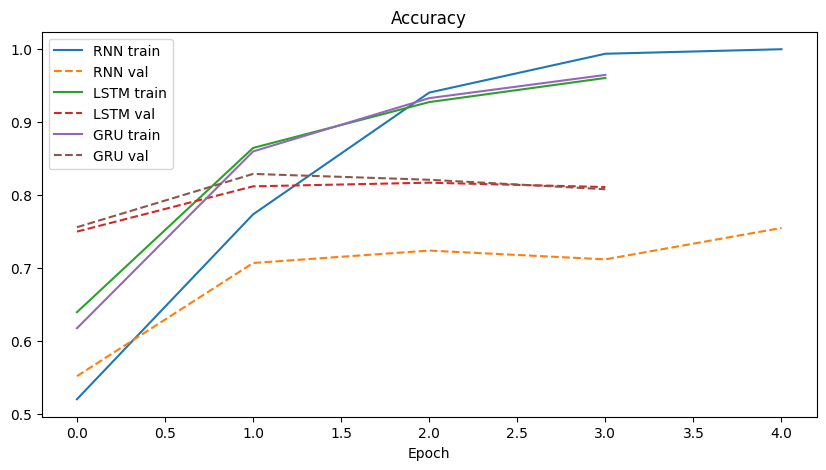

In [12]:
def plot_histories(histories, metric='accuracy'):
    plt.figure(figsize=(10,5))
    for name, h in histories.items():
        plt.plot(h.history[metric], label=f'{name} train')
        plt.plot(h.history['val_' + metric], '--', label=f'{name} val')
    plt.title(metric.capitalize())
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Example: after running training cells, call:
plot_histories({'RNN': history_rnn, 'LSTM': history_lstm, 'GRU': history_gru}, 'accuracy')

## 7) Evaluate and try sample predictions

Use the trained models to predict sentiment for custom sentences. We will show how to prepare text.

In [10]:
# Function to decode and predict
word_index = imdb.get_word_index()
index_word = {v+3:k for k,v in word_index.items()}  # Keras reserves indices 0-2 for special tokens
index_word[0] = '<PAD>'
index_word[1] = '<START>'
index_word[2] = '<UNK>'
index_word[3] = '<UNUSED>'

def decode_review(encoded_seq):
    return ' '.join([index_word.get(i, '?') for i in encoded_seq if i>3])

# Prepare new sentence using the tokenizer word index
import re

def encode_text(text, word_index, maxlen=200):
    # simple whitespace tokenizer mapping based on Keras imdb word_index
    tokens = re.sub(r"[^a-zA-Z0-9 ]", "", text.lower()).split()
    encoded = [word_index.get(w, 2) for w in tokens]  # 2 = <UNK>
    return pad_sequences([encoded], maxlen=maxlen)


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Example (run after model trained):
sample = "I absolutely loved this movie. Fantastic performances and great story."
x_sample = encode_text(sample, word_index, maxlen=MAXLEN)
print('RNN predicts:', model_rnn.predict(x_sample))
print('LSTM predicts:', model_lstm.predict(x_sample))
print('GRU predicts:', model_gru.predict(x_sample))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
RNN predicts: [[0.6070685]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
LSTM predicts: [[0.29297736]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
GRU predicts: [[0.96626276]]
